In [46]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

def matching(template_path, image_path, output_image_path, thresh=0.8, scales=None):
    # Load the main image
    img_rgb = cv.imread(image_path)
    assert img_rgb is not None, f"Main image at '{image_path}' could not be read, check the path."

    # Load the template (item) image in color
    template = cv.imread(template_path)
    assert template is not None, f"Template image at '{template_path}' could not be read, check the path."
    
    # Define transformations: original, mirrored, and rotated versions of the template
    transformations = {
        'original': template,
        'mirrored_lr': cv.flip(template, 1),  # Left-right mirrored
        'mirrored_ud': cv.flip(template, 0),  # Up-down mirrored
        'rotated_90': cv.rotate(template, cv.ROTATE_90_CLOCKWISE),
        'rotated_180': cv.rotate(template, cv.ROTATE_180),
        'rotated_270': cv.rotate(template, cv.ROTATE_90_COUNTERCLOCKWISE),
    }

    # Define the scales to search through
    if scales is None:
        scales = np.arange(0.5, 2.01, 0.01)

    total_matches = 0

    # Iterate through each transformation
    for transform_name, transformed_template in transformations.items():
        # Iterate through each scale and find all matches
        for scale in scales:
            # Resize the template according to the current scale
            scaled_template = cv.resize(transformed_template, (0, 0), fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
            scaled_w, scaled_h = scaled_template.shape[1], scaled_template.shape[0]

            # Perform template matching with the scaled template
            res = cv.matchTemplate(img_rgb, scaled_template, cv.TM_CCOEFF_NORMED)
            loc = np.where(res >= thresh)

            # Extract match points and their scores
            match_points = list(zip(*loc[::-1]))  # (x, y) coordinates of matches
            scores = res[loc]  # Match scores at those points

            # Sort match points by their scores in descending order
            sorted_points = sorted(zip(match_points, scores), key=lambda x: x[1], reverse=True)
            
            # Filter out points that are too close to each other
            unique_matches = []
            for (point, score) in sorted_points:
                x, y = point
                # Check if the current point is too close to any already accepted point
                if all(abs(x - mx) >= scaled_w and abs(y - my) >= scaled_h for (mx, my) in unique_matches):
                    unique_matches.append((x, y))

            # Draw rectangles around unique matches and count them
            for (x, y) in unique_matches:
                cv.rectangle(img_rgb, (x, y), (x + scaled_w, y + scaled_h), (0, 0, 255), 2)
                total_matches += 1

    # Save the result image with highlighted matches
    output_image_path = "find/" + output_image_path + ".jpg"
    cv.imwrite(output_image_path, img_rgb)
    print(f"Result saved to {output_image_path}")
    print(f"Total unique matches found: {total_matches}")

    # Display the result image with matches
    plt.imshow(cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB))
    plt.title('Matches')
    plt.axis('off')  # Hide the axis
    plt.show()


Result saved to find/count_cat.jpg
Total unique matches found: 1


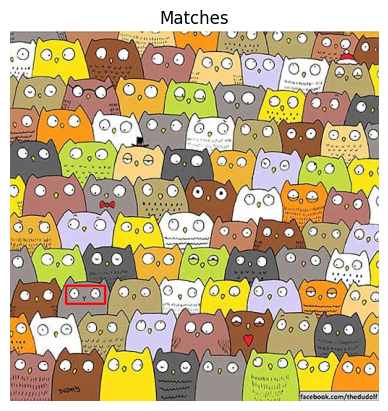

In [2]:
matching("cat_template.jpg", "cat.jpg", "count_cat", scales = [1])

Result saved to find/count_pboot_0.61.jpg
Total unique matches found: 11


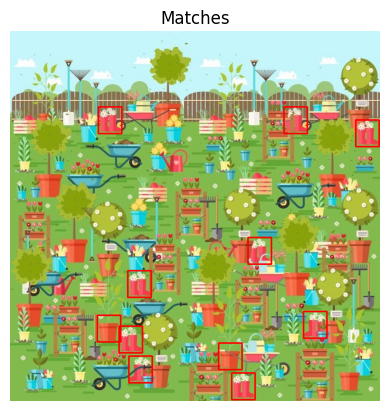

In [10]:
matching("pair_boot_template.jpg", "pair_boot.jpg", "count_pboot_0.61", scales= [1], thresh=0.61)

Result saved to find/count_pboot_0.62.jpg
Total unique matches found: 9


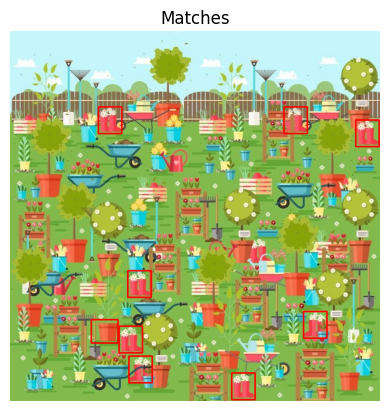

In [11]:
matching("pair_boot_template.jpg", "pair_boot.jpg", "count_pboot_0.62", scales= [1], thresh=0.62)

Result saved to find/count_pboot_0.63.jpg
Total unique matches found: 8


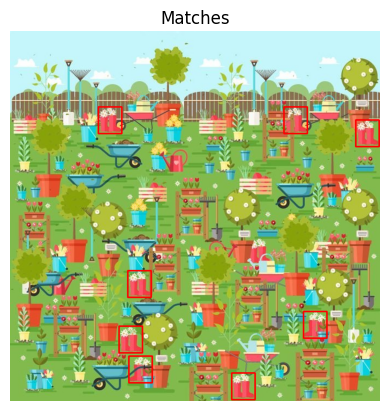

In [12]:
matching("pair_boot_template.jpg", "pair_boot.jpg", "count_pboot_0.63", scales= [1], thresh=0.63)

Result saved to find/count_rab1_face_templ.jpg
Total unique matches found: 13


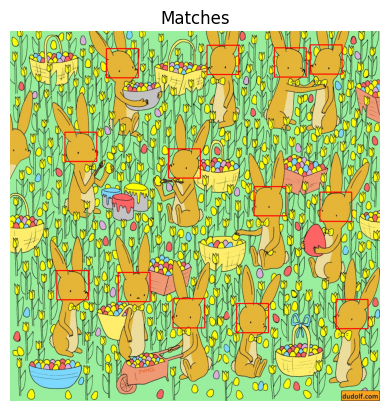

In [22]:
matching("rab1_face_templ.jpeg", "rabbit.jpeg", "count_rab1_face_templ", scales= [1], thresh= 0.35)

Result saved to find/count_rab2_eyesnose.jpg
Total unique matches found: 20


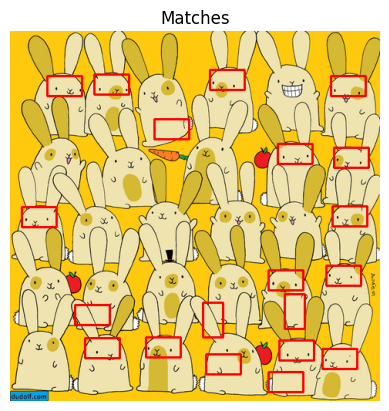

In [25]:
matching("rab2_eyesnose_templ.png", "rabbit2.png", "count_rab2_eyesnose", scales= [1], thresh= 0.4)

# Make a matching that focus more on black

In [48]:

def black_focused_matching(template_path, image_path, output_image_path, thresh=0.8, black_focus_ratio=0.7, scales=None):
    # Load the main image
    img_rgb = cv.imread(image_path)
    assert img_rgb is not None, f"Main image at '{image_path}' could not be read, check the path."

    # Load the template (item) image in color
    template = cv.imread(template_path)
    assert template is not None, f"Template image at '{template_path}' could not be read, check the path."
    
    # Convert the main image and template to grayscale for blackness focus
    img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
    template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    
    # Define transformations: original, mirrored, and rotated versions of the template
    transformations = {
        'original': template,
        'mirrored_lr': cv.flip(template, 1),  # Left-right mirrored
        'mirrored_ud': cv.flip(template, 0),  # Up-down mirrored
        'rotated_90': cv.rotate(template, cv.ROTATE_90_CLOCKWISE),
        'rotated_180': cv.rotate(template, cv.ROTATE_180),
        'rotated_270': cv.rotate(template, cv.ROTATE_90_COUNTERCLOCKWISE),
    }
    
    # Define grayscale versions of these transformations for blackness score calculation
    gray_transformations = {k: cv.cvtColor(v, cv.COLOR_BGR2GRAY) for k, v in transformations.items()}

    # Define the scales to search through
    if scales is None:
        scales = np.arange(0.5, 2.01, 0.01)

    total_matches = 0

    # Iterate through each transformation
    for transform_name, transformed_template in transformations.items():
        transformed_gray_template = gray_transformations[transform_name]

        # Iterate through each scale and find all matches
        for scale in scales:
            # Resize the template according to the current scale
            scaled_template = cv.resize(transformed_template, (0, 0), fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
            scaled_gray_template = cv.resize(transformed_gray_template, (0, 0), fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
            scaled_w, scaled_h = scaled_template.shape[1], scaled_template.shape[0]

            # Perform template matching for both color and grayscale
            color_res = cv.matchTemplate(img_rgb, scaled_template, cv.TM_CCOEFF_NORMED)
            black_res = cv.matchTemplate(img_gray, scaled_gray_template, cv.TM_CCOEFF_NORMED)

            # Combine the scores using the black_focus_ratio
            combined_res = black_focus_ratio * black_res + (1 - black_focus_ratio) * color_res
            loc = np.where(combined_res >= thresh)

            # Extract match points and their scores
            match_points = list(zip(*loc[::-1]))  # (x, y) coordinates of matches
            scores = combined_res[loc]  # Combined match scores at those points

            # Sort match points by their scores in descending order
            sorted_points = sorted(zip(match_points, scores), key=lambda x: x[1], reverse=True)
            
            # Filter out points that are too close to each other
            unique_matches = []
            for (point, score) in sorted_points:
                x, y = point
                # Check if the current point is too close to any already accepted point
                if all(abs(x - mx) >= scaled_w and abs(y - my) >= scaled_h for (mx, my) in unique_matches):
                    unique_matches.append((x, y))

            # Draw rectangles around unique matches and count them
            for (x, y) in unique_matches:
                cv.rectangle(img_rgb, (x, y), (x + scaled_w, y + scaled_h), (0, 0, 255), 2)
                total_matches += 1

    # Save the result image with highlighted matches
    output_image_path = "find/" + output_image_path + ".jpg"
    cv.imwrite(output_image_path, img_rgb)
    print(f"Result saved to {output_image_path}")
    print(f"Total unique matches found: {total_matches}")

    # Display the result image with matches
    plt.imshow(cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB))
    plt.title('Matches')
    plt.axis('off')  # Hide the axis
    plt.show()


Result saved to find/count_rab2_bfm_eyesnose.jpg
Total unique matches found: 10


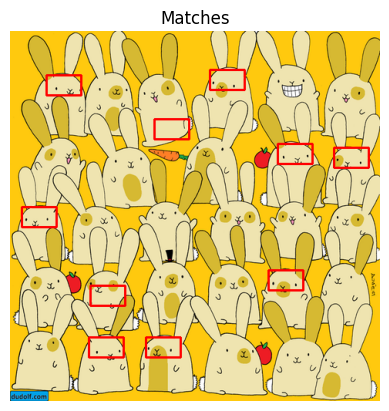

In [49]:
black_focused_matching("rab2_eyesnose_templ.png", "rabbit2.png", "count_rab2_bfm_eyesnose", scales= [1], thresh= 0.4)

Result saved to find/count_rab2_0.5bfm_eyesnose.jpg
Total unique matches found: 12


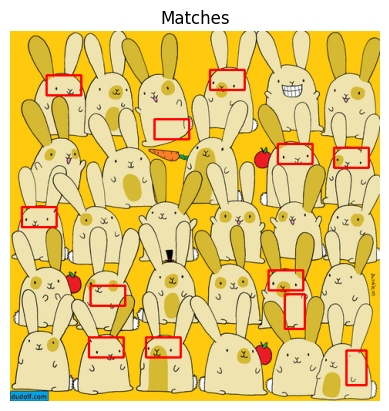

In [55]:
black_focused_matching("rab2_eyesnose_templ.png", "rabbit2.png", "count_rab2_0.5bfm_eyesnose", scales= [1], thresh= 0.4, black_focus_ratio=0.5)

Result saved to find/count_rab2_bfm_face.jpg
Total unique matches found: 13


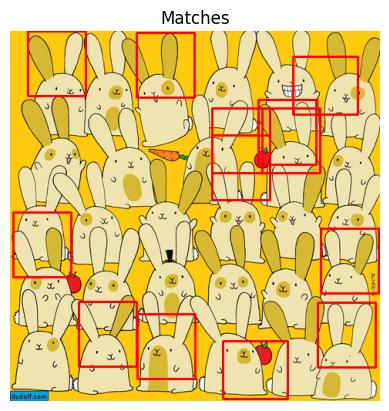

In [51]:
black_focused_matching("rab2_face.png", "rabbit2.png", "count_rab2_bfm_face", scales= [1], thresh= 0.2, black_focus_ratio=0.7)

# Im just gonna do the mouse now

Result saved to find/count_mouse_head.jpg
Total unique matches found: 1


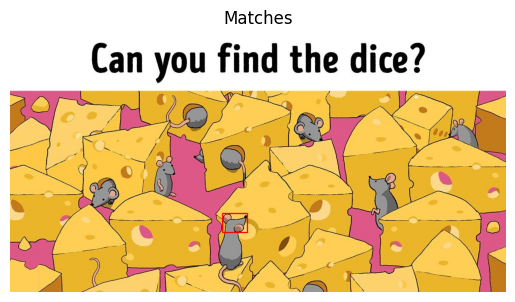

In [76]:
matching("mouse_head_templ.jpg", "mouse.jpg", "count_mouse_head", scales=[1], thresh=0.5)

Result saved to find/count_mouse_bfm_head.jpg
Total unique matches found: 16


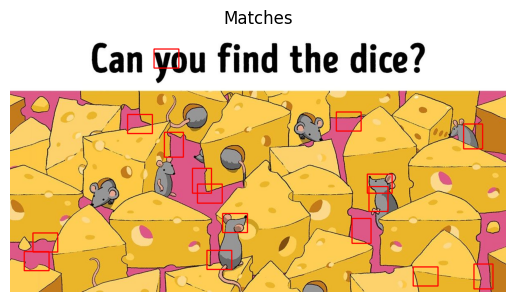

In [74]:
black_focused_matching("mouse_head_templ.jpg", "mouse.jpg", "count_mouse_bfm_head", scales=[1], thresh=0.3, black_focus_ratio=0.4)

Result saved to find/count_mouse_butt.jpg
Total unique matches found: 2


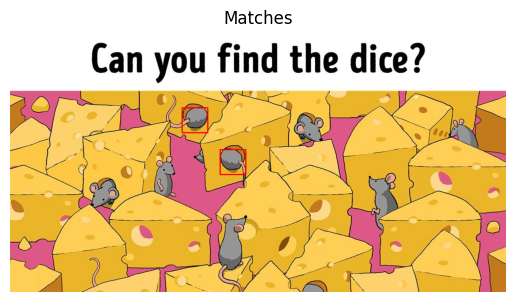

In [77]:
matching("mouse_butt_templ.jpg", "mouse.jpg", "count_mouse_butt", scales=[1], thresh=0.7)

Result saved to find/count_mouse_bfm_butt.jpg
Total unique matches found: 8


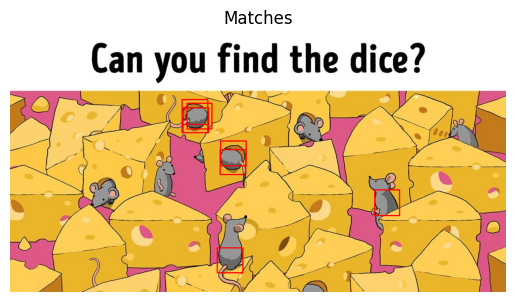

In [92]:
black_focused_matching("mouse_butt_templ.jpg", "mouse.jpg", "count_mouse_bfm_butt", scales=[1], thresh=0.4, black_focus_ratio=0.4)

Result saved to find/count_mouse_head2.jpg
Total unique matches found: 1


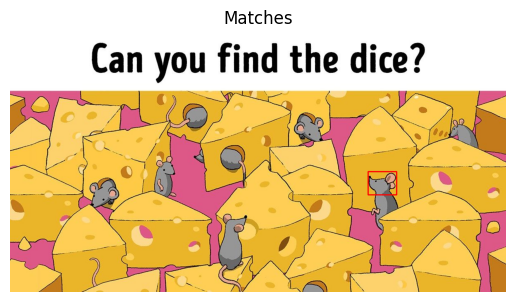

In [94]:
matching("mouse_head_templ2.jpg", "mouse.jpg", "count_mouse_head2", scales=[1], thresh=0.5)

Result saved to find/count_mouse_bfm_head2.jpg
Total unique matches found: 6


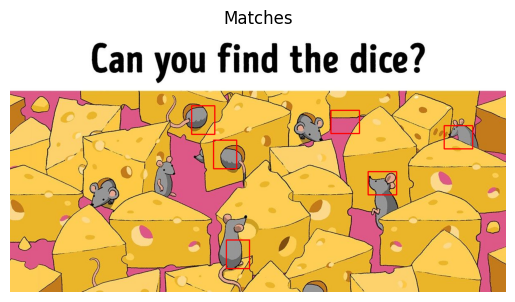

In [108]:
black_focused_matching("mouse_head_templ2.jpg", "mouse.jpg", "count_mouse_bfm_head2", scales=[1], thresh=0.3, black_focus_ratio=0.4)